In [1]:
using Pkg
Pkg.activate("climate"; shared=true)

"/Users/imolk/Library/Julia/environments/climate/Project.toml"

In [2]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!
import Proj4
using Optim
using Distances
import TempModel
;

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [4]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

┌ Warning: Environment variable CMDSTAN_HOME not found. Use set_cmdstan_home!.
└ @ Stan /Users/imolk/Library/Julia/packages/Stan/a6xnA/src/Stan.jl:18
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41


# `sumprod` sum of products kernel

In [5]:
k1 = fix(Periodic(log(1.0),log(3.0),log(24.0)), :lp)
k2 = RQIso(log(0.5),0.0,0.0)  # half an hour
k3 = RQIso(log(2.0),0.0,0.0)  # two hours
k4 = RQIso(log(12.0),0.0,0.0) # twelve hours

ksp1 = fix(Mat32Iso(log(5e4), log(1.0)), :lσ)
ksp2 = fix(Mat32Iso(log(5e4), log(1.0)), :lσ)
ksp3 = fix(Mat32Iso(log(5e4), log(1.0)), :lσ)
ksp4 = fix(Mat32Iso(log(5e4), log(1.0)), :lσ)
k_means = SEIso(log(1), log(10.0))

k_spatiotemporal = Masked(k1, [1]) * Masked(ksp1, [2,3]) +
                 Masked(k2, [1])  * Masked(ksp2, [2,3]) +
                 Masked(k3, [1]) * Masked(ksp3, [2,3]) +
                 Masked(k4, [1])  * Masked(ksp4, [2,3]) +
                 fix(Masked(k_means, [2,3]))
;

# optimize

In [6]:
@time opt_out = TempModel.optim_kernel(k_spatiotemporal, 0.0, iowa[:isdSubset], iowa[:hourly_data], :Optim);

LinearAlgebra.PosDefException(17)
LinearAlgebra

  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41


.PosDefException(13)
12028.114757 seconds (27.99 M allocations: 7.943 GiB, 0.02% gc time)


In [7]:
opt_out[:mll]

-45954.011994964836

In [8]:
print(opt_out[:hyp])

[-1.72361, -0.200613, 1.0075, 14.0162, -1.20089, -0.703055, -1.07354, 9.35237, 0.678935, -0.0278533, 0.244548, 11.1962, 2.18646, 1.45579, -0.924148, 13.3052]

In [9]:
opt_out[:opt_out]

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-1.7236128513635947,-0.20061305155304007, ...]
 * Minimum: 4.595401e+04
 * Iterations: 236
 * Convergence: true
   * |x - x'| ≤ 1.0e-05: false 
     |x - x'| = 1.09e-04 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 8.35e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.01e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 479
 * Gradient Calls: 248

In [16]:
import Printf
using Printf: @printf
print("k₁: Periodic \n=================\n")
Printf.@printf("σ: %5.3f\n", √k1.kernel.σ2)
Printf.@printf("l: %5.3f\n", √k1.kernel.ℓ2)
Printf.@printf("p: %5.0f hours\n", k1.kernel.p)
print("> spatial decay:\n")
Printf.@printf("l: %5.3f km\n", ksp1.kernel.ℓ / 1000)
print("\nk₂: RQIso \n=================\n")
Printf.@printf("σ: %5.3f\n", √k2.σ2)
Printf.@printf("l: %5.3f hours\n", √ k2.ℓ2)
Printf.@printf("α: %5.3f\n", k2.α)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp2.σ2)
Printf.@printf("l: %5.3f km\n", ksp2.kernel.ℓ / 1000)
print("\nk₃: SEIso \n=================\n")
Printf.@printf("σ: %5.3f\n", √k3.σ2)
Printf.@printf("l: %5.3f hours\n", √k3.ℓ2)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp3.σ2)
Printf.@printf("l: %5.3f km\n", ksp3.kernel.ℓ / 1000)
print("\nk₄: RQIso \n=================\n")
Printf.@printf("σ: %5.3f\n", √k4.σ2)
Printf.@printf("l: %5.3f days\n", √k4.ℓ2 / 24)
Printf.@printf("α: %5.3f\n",  k4.α)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp4.σ2)
Printf.@printf("l: %5.3f km\n", ksp4.kernel.ℓ / 1000)
print("\n=================\n")
Printf.@printf("σy: %5.3f\n", exp(opt_out[:hyp][1]))

k₁: Periodic 
σ: 2.739
l: 0.818
p:    24 hours
> spatial decay:
l: 1222.258 km

k₂: RQIso 
σ: 0.495
l: 0.301 hours
α: 0.342
> spatial decay:
l: 11.526 km

k₃: SEIso 
σ: 0.973
l: 1.972 hours
> spatial decay:
l: 72.850 km

k₄: RQIso 
σ: 4.288
l: 0.371 days
α: 0.397
> spatial decay:
l: 600.282 km

σy: 0.178


# Plotting fitted variogram

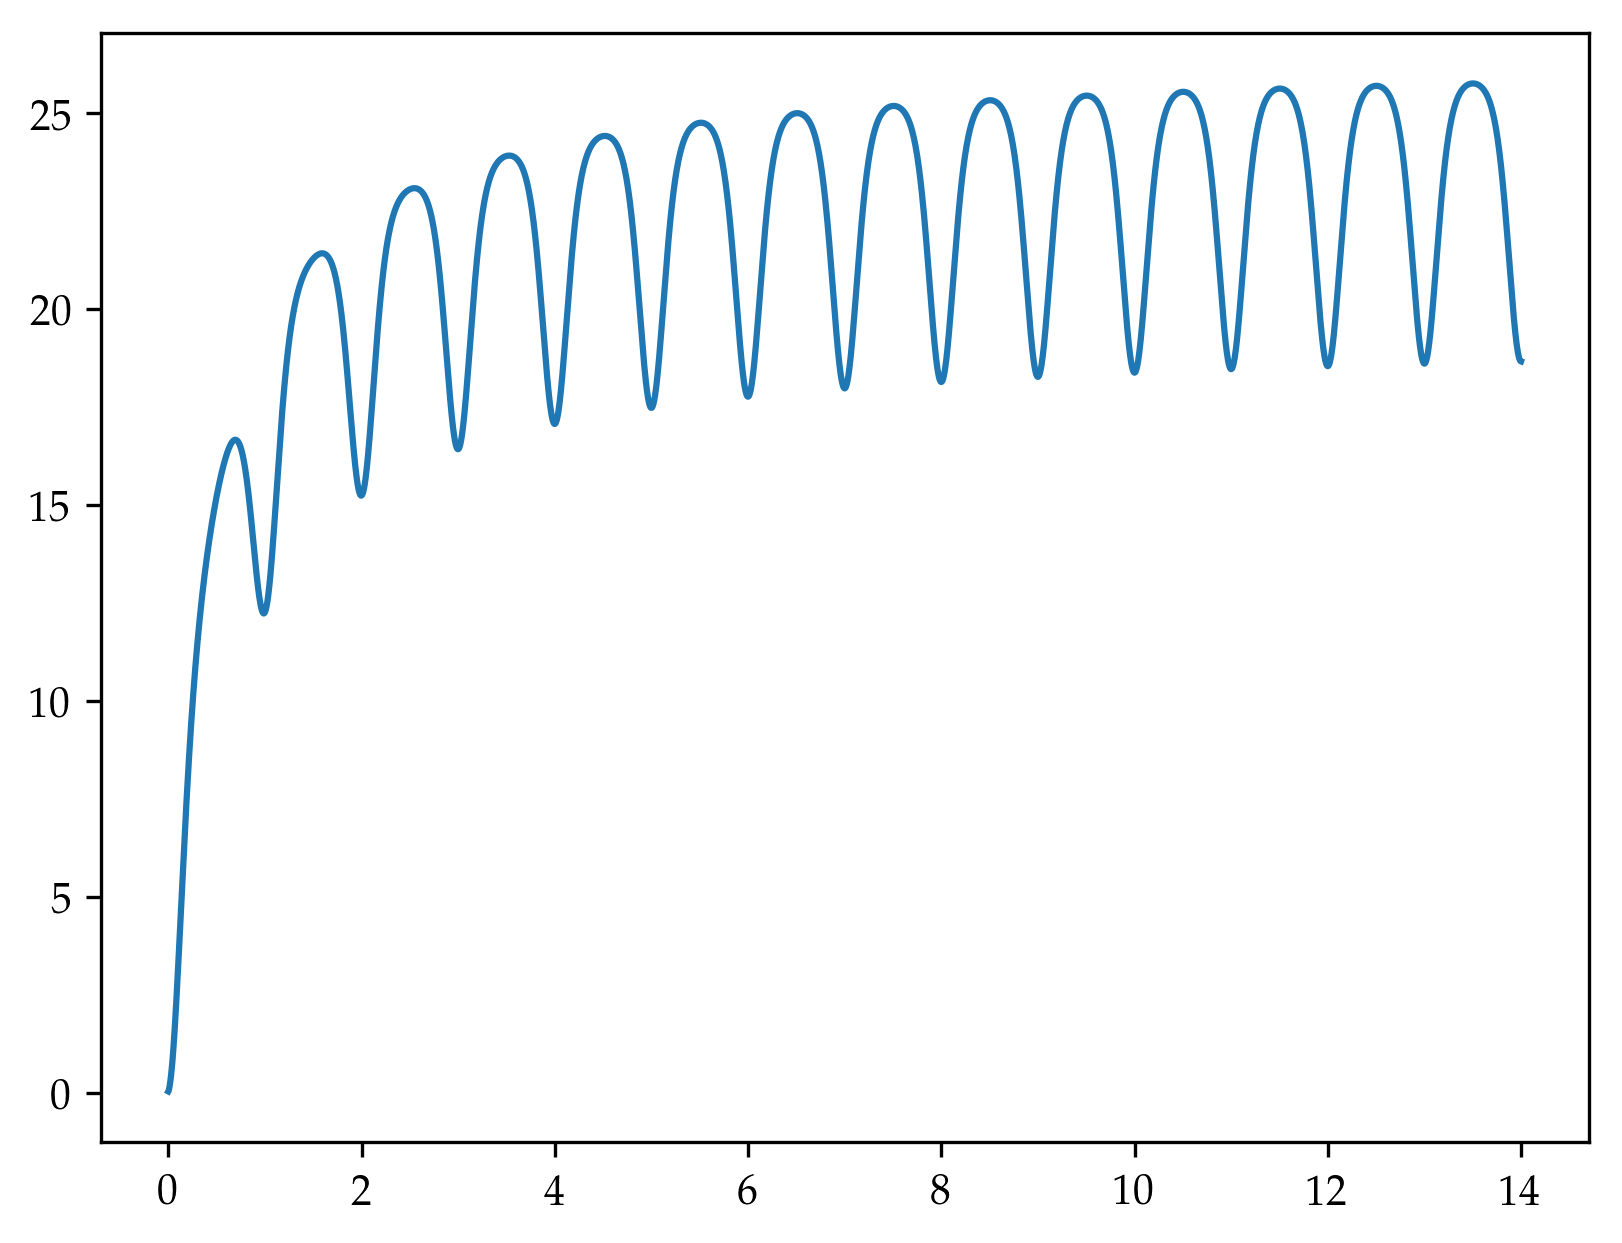

In [19]:
σ2_y = exp(2*opt_out[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(k_spatiotemporal, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;